In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from huggingface_hub import hf_hub_download

from uni2ts.eval_util.plot import plot_single, plot_next_multi
from uni2ts.model.moirai import MoiraiForecast

### Settings
SIZE: model size, select the model size of Moirai to perform inference with

PDT: prediction length, how many time steps to predict into the future

CTX: context length, how many time steps the model will take as input for inference

PSZ: patch size, how many time steps to perform patching with

BSZ: batch size, number of samples in each batch for inference

TEST: test set length, number of time steps to hold out for test set

In [2]:
SIZE = "small"  # model size: choose from {'small', 'base', 'large'}
PDT = 20  # prediction length: any positive integer
CTX = 200  # context length: any positive integer
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 32  # batch size: any positive integer
TEST = 100  # test set length: any positive integer

# 1. Loading from a _long_ DataFrame

In [3]:
# Load dataframe
url = (
    "https://gist.githubusercontent.com/rsnirwan/a8b424085c9f44ef2598da74ce43e7a3"
    "/raw/b6fdef21fe1f654787fa0493846c546b7f9c4df2/ts_long.csv"
)
df = pd.read_csv(url, index_col=0, parse_dates=True)

df.head()

,target,item_id
2021-01-01 00:00:00,-1.3378,A
2021-01-01 01:00:00,-1.6111,A
2021-01-01 02:00:00,-1.9259,A
2021-01-01 03:00:00,-1.9184,A
2021-01-01 04:00:00,-1.9168,A


In [4]:
# Convert into GluonTS dataset
ds = PandasDataset.from_long_dataframe(df, target="target", item_id="item_id")

# Split into train/test set
train, test_template = split(
    ds, offset=-TEST
)  # assign last TEST time steps as test set

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)

In [5]:
# Prepare model
model = MoiraiForecast.load_from_checkpoint(
    checkpoint_path=hf_hub_download(
        repo_id=f"Salesforce/moirai-1.0-R-{SIZE}", filename="model.ckpt"
    ),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    map_location="cuda:0" if torch.cuda.is_available() else "cpu",
)

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

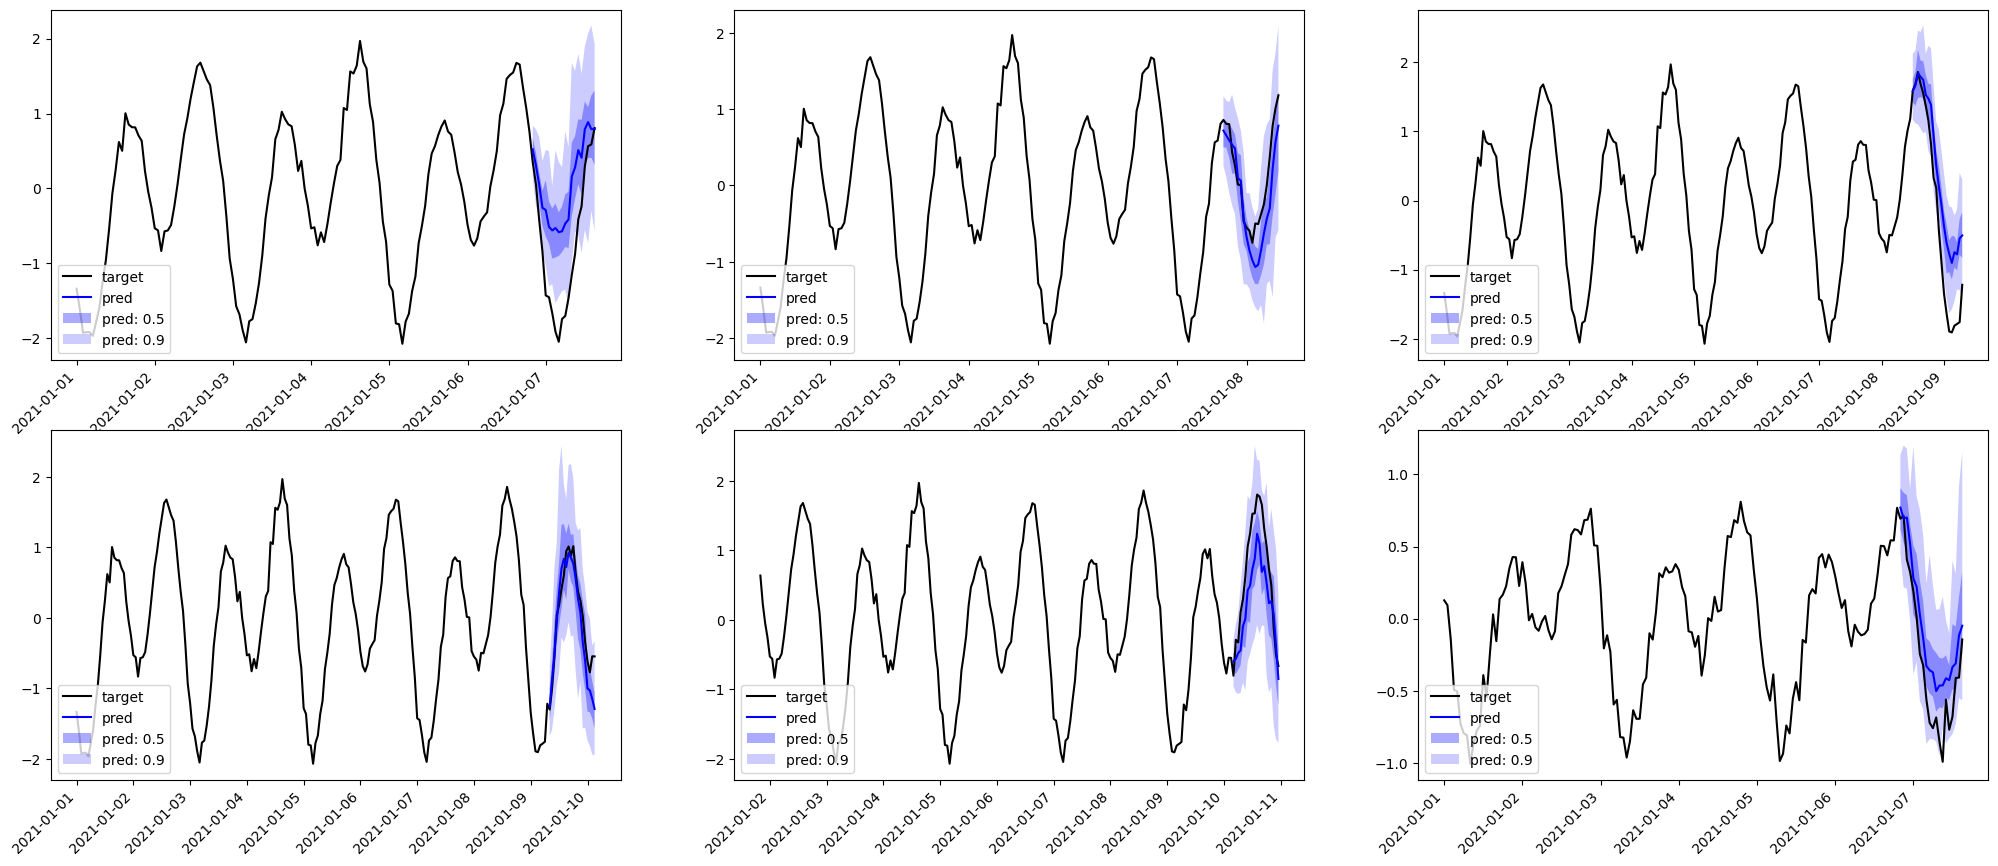

In [6]:
# Make predictions
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
plot_next_multi(
    axes,
    input_it,
    label_it,
    forecast_it,
    context_length=200,
    intervals=(0.5, 0.9),
    dim=None,
    name="pred",
    show_label=True,
)

# 2. Loading from a _wide_ DataFrame

In [7]:
# Load dataframe
url_wide = (
    "https://gist.githubusercontent.com/rsnirwan/c8c8654a98350fadd229b00167174ec4"
    "/raw/a42101c7786d4bc7695228a0f2c8cea41340e18f/ts_wide.csv"
)
df = pd.read_csv(url_wide, index_col=0, parse_dates=True)

df.head()

,A,B,C,D,E,F,G,H,I,J
2021-01-01 00:00:00,-1.3378,0.1268,-0.3645,-1.0864,-2.3803,-0.2447,2.2647,-0.7917,0.7071,1.3763
2021-01-01 01:00:00,-1.6111,0.0926,-0.1364,-1.1613,-2.1421,-0.3477,2.4262,-0.9609,0.6413,1.2750
2021-01-01 02:00:00,-1.9259,-0.1420,0.1063,-1.0405,-2.1426,-0.3271,2.4434,-0.9034,0.4323,0.6767
2021-01-01 03:00:00,-1.9184,-0.4930,0.6269,-0.8531,-1.7060,-0.3088,2.4307,-0.9602,0.3193,0.5150
2021-01-01 04:00:00,-1.9168,-0.5057,0.9419,-0.7666,-1.4287,-0.4284,2.3258,-1.2504,0.3660,0.1708


In [8]:
# Convert into GluonTS dataset
ds = PandasDataset(dict(df))

# Split into train/test set
train, test_template = split(
    ds, offset=-TEST
)  # assign last TEST time steps as test set

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)

In [9]:
# Prepare model
model = MoiraiForecast.load_from_checkpoint(
    checkpoint_path=hf_hub_download(
        repo_id=f"Salesforce/moirai-R-{SIZE}", filename="model.ckpt"
    ),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    map_location="cuda:0" if torch.cuda.is_available() else "cpu",
)

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

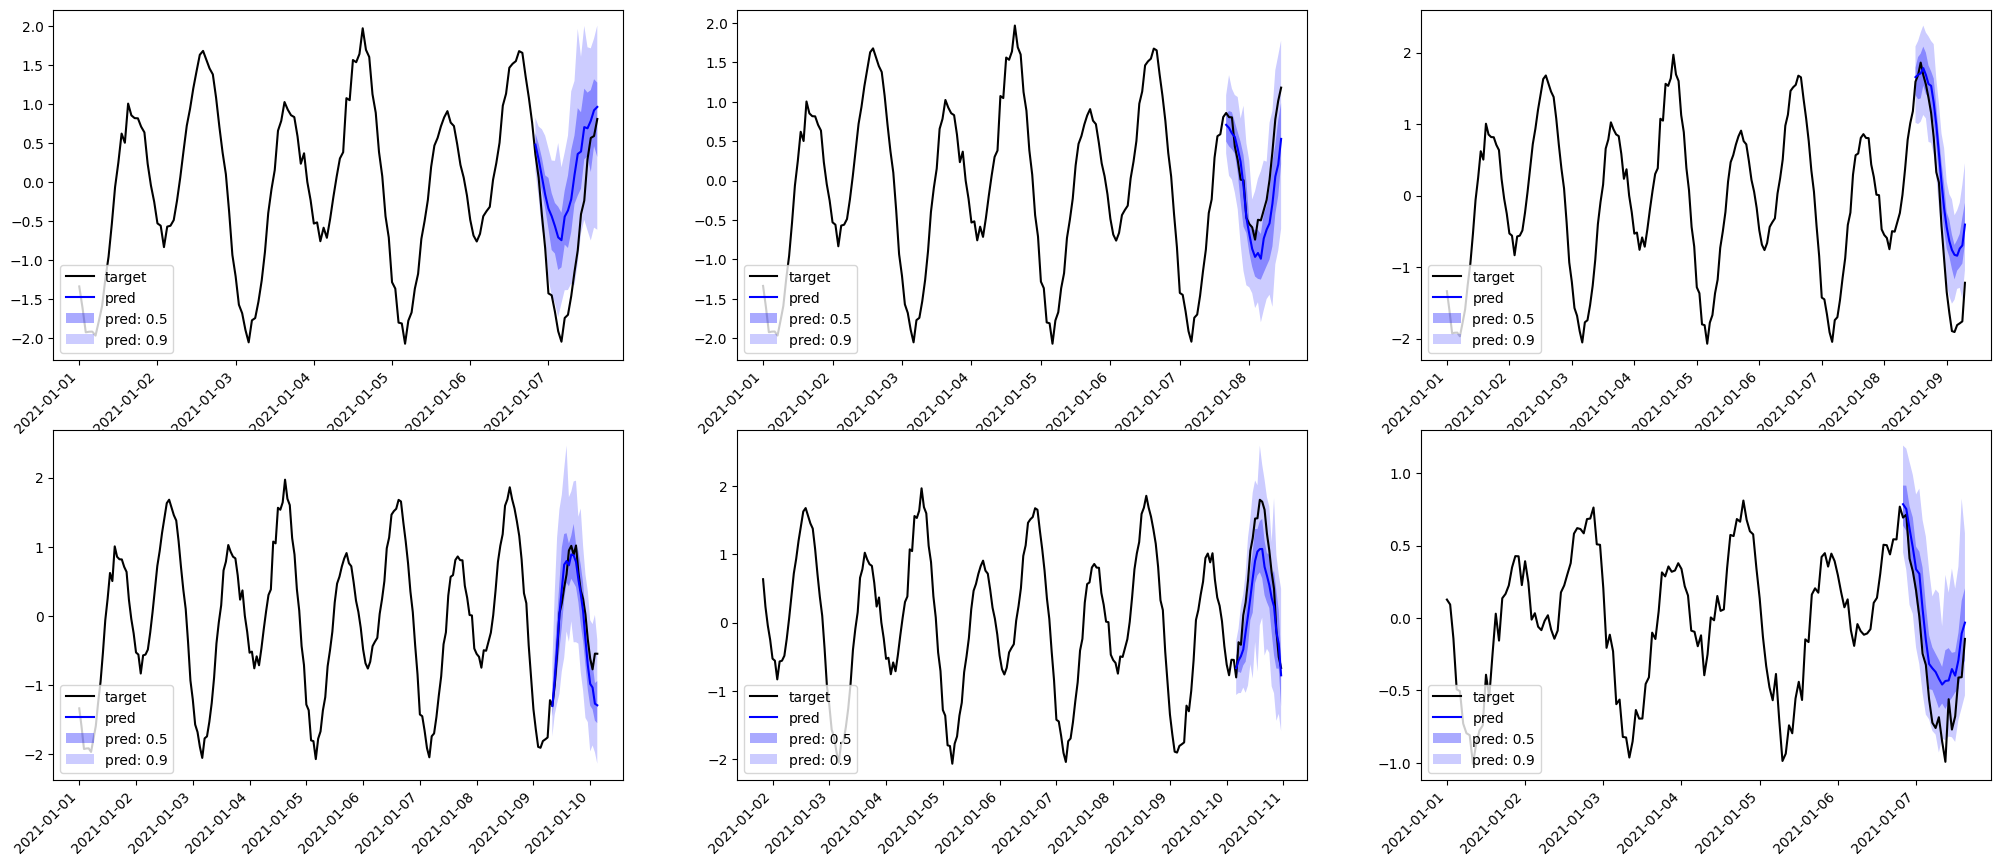

In [10]:
# Make predictions
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
plot_next_multi(
    axes,
    input_it,
    label_it,
    forecast_it,
    context_length=200,
    intervals=(0.5, 0.9),
    dim=None,
    name="pred",
    show_label=True,
)

# 3. Multivariate Forecasting

In [11]:
# Load dataframe
url_wide = (
    "https://gist.githubusercontent.com/rsnirwan/c8c8654a98350fadd229b00167174ec4"
    "/raw/a42101c7786d4bc7695228a0f2c8cea41340e18f/ts_wide.csv"
)
df = pd.read_csv(url_wide, index_col=0, parse_dates=True)

In [12]:
# Convert into GluonTS dataset
ds = PandasDataset(dict(df))

# Group time series into multivariate dataset
grouper = MultivariateGrouper(len(ds))
multivar_ds = grouper(ds)

# Split into train/test set
train, test_template = split(
    multivar_ds, offset=-TEST
)  # assign last TEST time steps as test set

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)

In [13]:
# Prepare model
model = MoiraiForecast.load_from_checkpoint(
    checkpoint_path=hf_hub_download(
        repo_id=f"Salesforce/moirai-R-{SIZE}", filename="model.ckpt"
    ),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=len(ds),
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    map_location="cuda:0" if torch.cuda.is_available() else "cpu",
)

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

In [14]:
# Make predictions
inp = next(input_it)
label = next(label_it)
forecast = next(forecast_it)

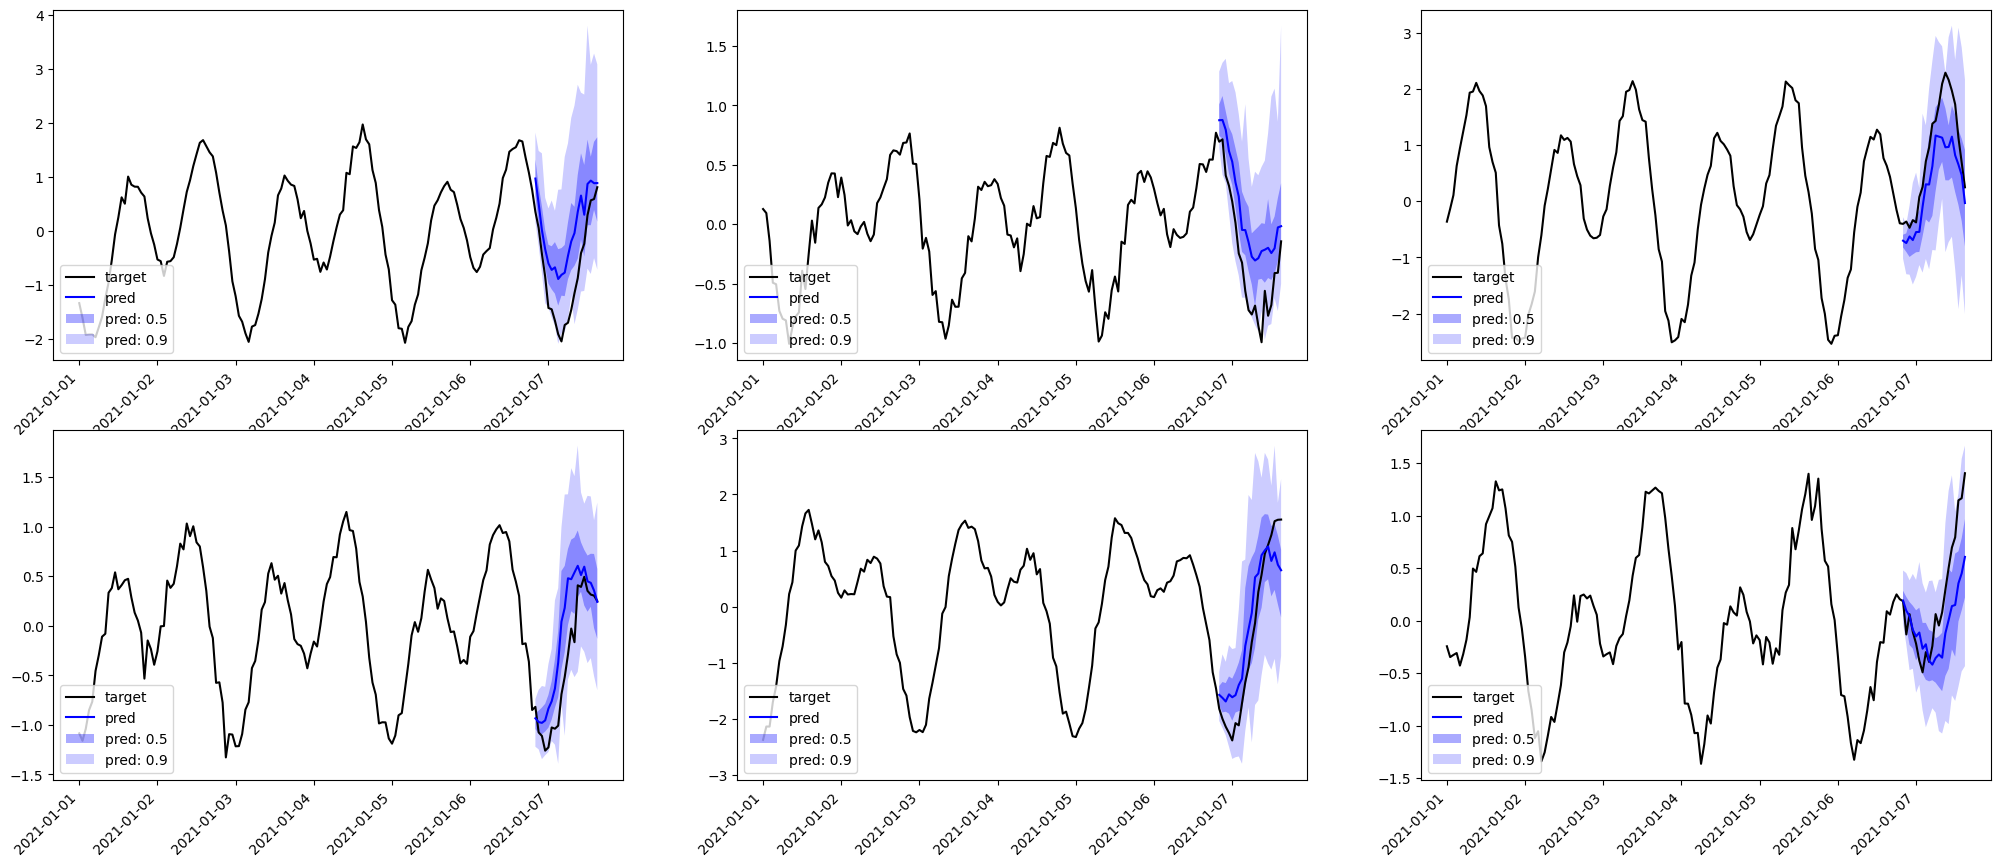

In [15]:
# Visualize different dimensions
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
for i, ax in enumerate(axes.flatten()):
    plot_single(
        inp,
        label,
        forecast,
        context_length=200,
        intervals=(0.5, 0.9),
        dim=i,
        ax=ax,
        name="pred",
        show_label=True,
    )

# 4. Include dynamic features

In [18]:
# Generate synthetic data with dynamic features
def generate_single_ts(date_range, item_id=None) -> pd.DataFrame:
    """create sum of `n_f` sin/cos curves with random scale and phase."""
    n_f = 2
    period = np.array([24 / (i + 1) for i in range(n_f)]).reshape(1, n_f)
    scale = np.random.normal(1, 0.3, size=(1, n_f))
    phase = 2 * np.pi * np.random.uniform(size=(1, n_f))
    periodic_f = lambda x: scale * np.sin(np.pi * x / period + phase)

    t = np.arange(0, len(date_range)).reshape(-1, 1)
    target = periodic_f(t).sum(axis=1) + np.random.normal(0, 0.1, size=len(t))
    ts = pd.DataFrame({"target": target}, index=date_range)
    if item_id is not None:
        ts["item_id"] = item_id
    return ts

def generate_single_ts_with_features(date_range, item_id=None) -> pd.DataFrame:
    ts = generate_single_ts(date_range, item_id)
    T = ts.shape[0]
    ts["dynamic_real_1"] = np.random.normal(size=T)
    ts["past_dynamic_real_2"] = np.random.normal(size=T)
    return ts
    
freq = "1H"
T = 20 * PDT
date_range = pd.date_range("2000-01-01", periods=T, freq=freq)
N = 3

multiple_ts = {
    i: generate_single_ts_with_features(date_range, item_id=i) for i in range(N)
}

In [19]:
# Convert wide dateframe into GluonTS dataset
multiple_ts_dataset = PandasDataset(
    multiple_ts,
    past_feat_dynamic_real=["past_dynamic_real_2"], 
    feat_dynamic_real=["dynamic_real_1"],
)

# Split into train/test set
train, test_template = split(
    multiple_ts_dataset, offset=-TEST
)  # assign last TEST time steps as test set

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)

In [20]:
# Prepare model
model = MoiraiForecast.load_from_checkpoint(
    checkpoint_path=hf_hub_download(
        repo_id=f"Salesforce/moirai-R-{SIZE}", filename="model.ckpt"
    ),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=multiple_ts_dataset.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=multiple_ts_dataset.num_past_feat_dynamic_real,
    map_location="cuda:0" if torch.cuda.is_available() else "cpu",
)

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

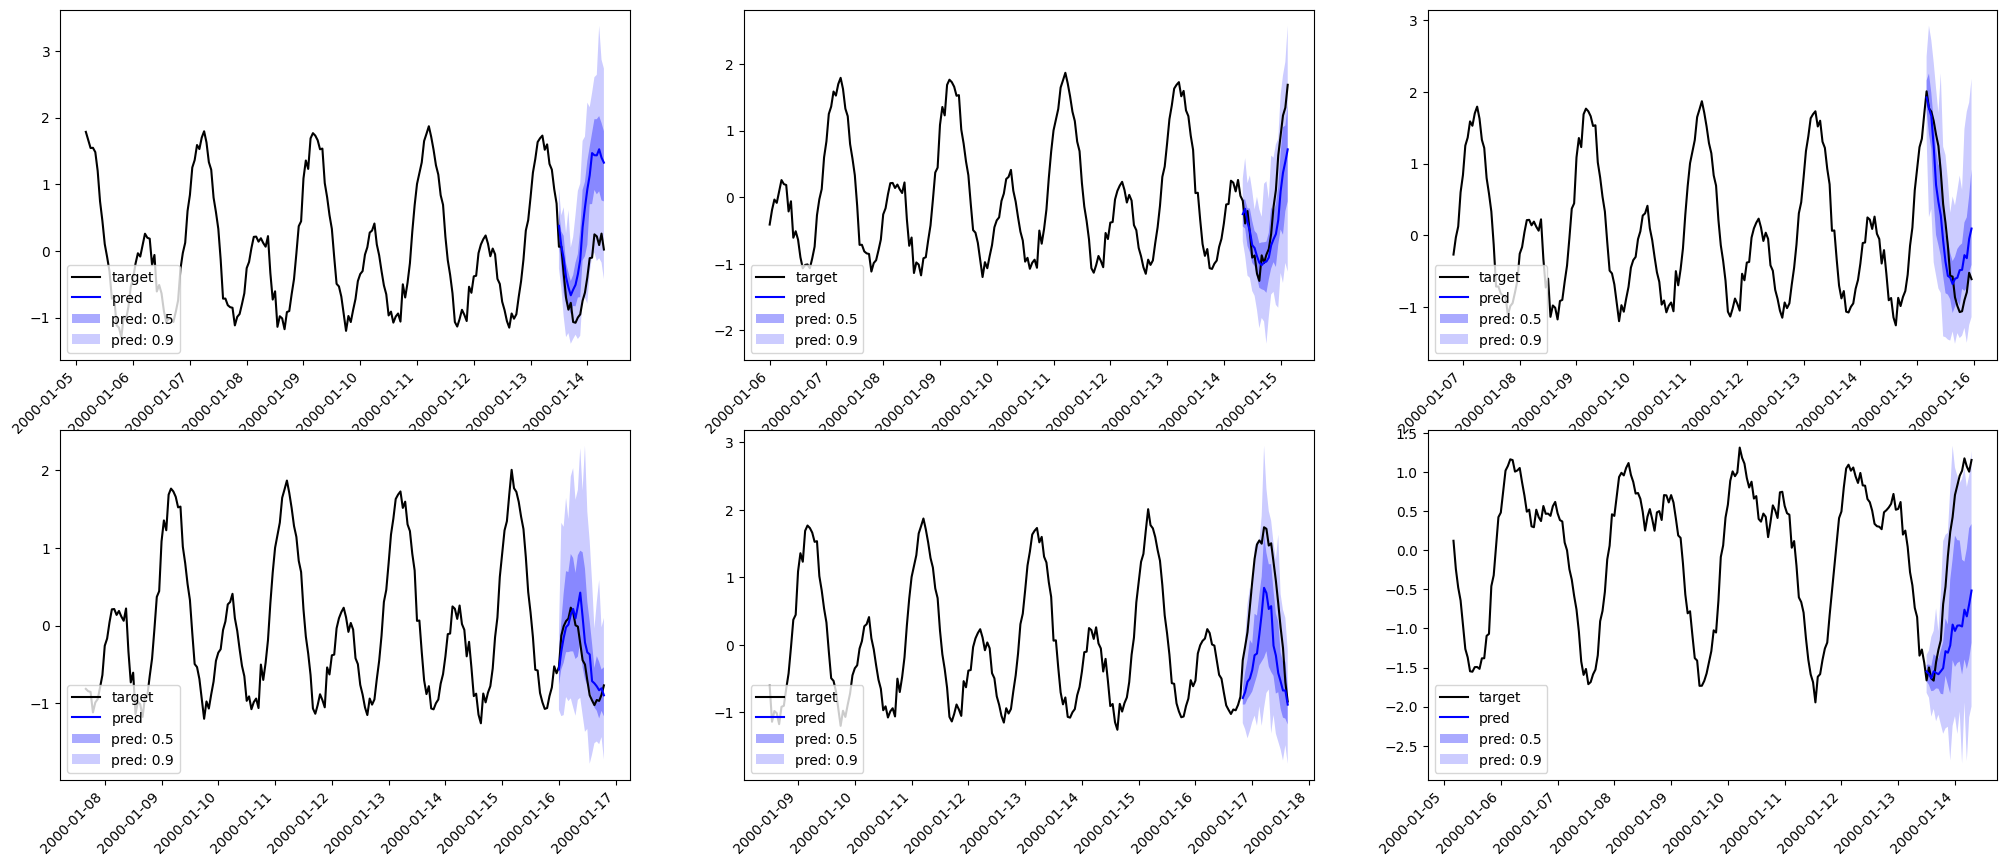

In [21]:
# Make predictions
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
plot_next_multi(
    axes,
    input_it,
    label_it,
    forecast_it,
    context_length=200,
    intervals=(0.5, 0.9),
    dim=None,
    name="pred",
    show_label=True,
)

In [22]:
# Convert long dateframe into GluonTS dataset
multiple_ts_long = pd.concat(multiple_ts.values())

multiple_ts_long_dataset = PandasDataset.from_long_dataframe(
    multiple_ts_long,
    item_id="item_id",
    past_feat_dynamic_real=["past_dynamic_real_2"], 
    feat_dynamic_real=["dynamic_real_1"],
)

# Split into train/test set
train, test_template = split(
    multiple_ts_long_dataset, offset=-TEST
)  # assign last TEST time steps as test set

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)

In [23]:
# Prepare model
model = MoiraiForecast.load_from_checkpoint(
    checkpoint_path=hf_hub_download(
        repo_id=f"Salesforce/moirai-R-{SIZE}", filename="model.ckpt"
    ),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=multiple_ts_long_dataset.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=multiple_ts_long_dataset.num_past_feat_dynamic_real,
    map_location="cuda:0" if torch.cuda.is_available() else "cpu",
)

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

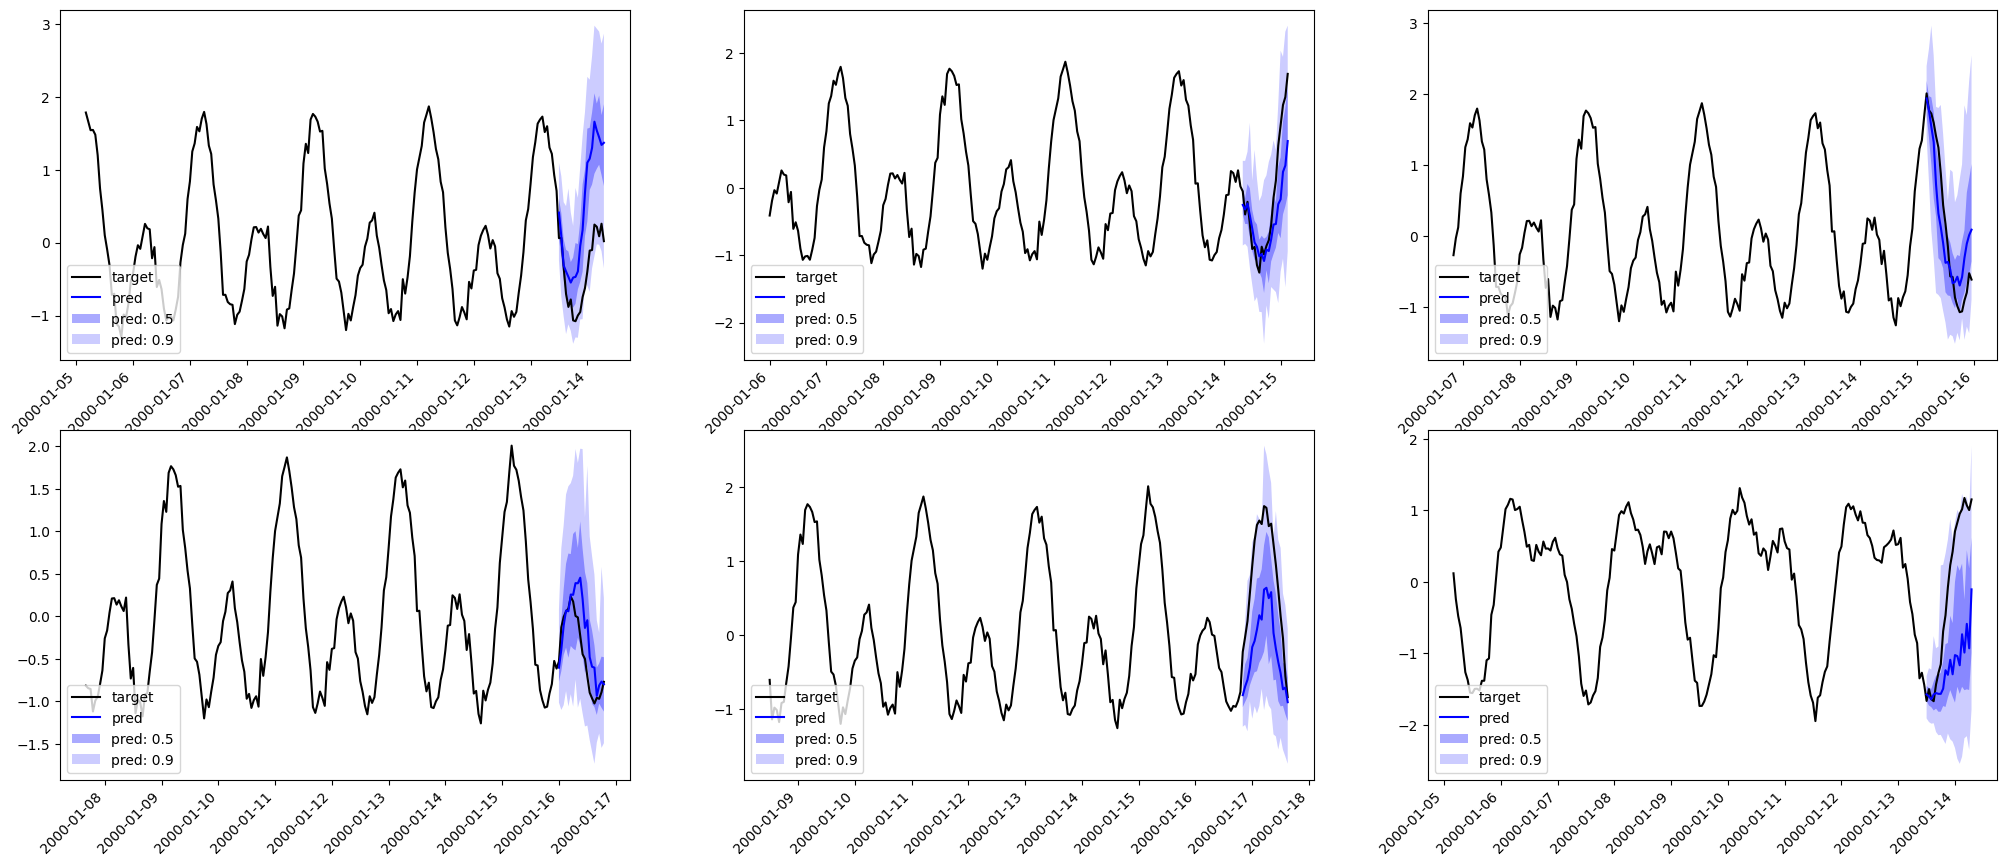

In [24]:
# Make predictions
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
plot_next_multi(
    axes,
    input_it,
    label_it,
    forecast_it,
    context_length=200,
    intervals=(0.5, 0.9),
    dim=None,
    name="pred",
    show_label=True,
)